# Introducción
## Objetivo
Este programa se tuiliza para asignar grupos a estudiantes siguiendo las prioridades:
* Todos los estudiantes (o la mayor cantidad posible), deberían ser asignados a un grupo que hayan marcado como deseable
* Los estudiantes que presentan certificado laboral/deportivo recibem prioridad al momento de la asignación grupos

## Resultado
El programa genera como archivo de salida una tabla en la que se indica el grupo asignado a cada estudiante. En una columna adicional se indica si el turno asignado se encuentra entre los elegidos por el estudiante.

## Reglas
### Sobre los grupos
* Existe un numero $n$ de grupos
* Cada grupo $n_i$ tiene un numero determinado de cupos $c_i$
* Los grupos estan agregados en $S$ *supergrupos* que pueden corresponder a turnos (Matutino, Vespertino, Nocturno), salones de clase, centros de estudio, etc. Cada grupo $n_i$ pertenece a un único supergrupo $S_j$

### Sobre los estudiantes
* Existen $m$ estudiantes. Identificados por un número de cedula o pasaporte.
* Cada estudiante debe elegir al menos 1 grupo en al menos 2 supergrupos diferentes (Todos los estudiantes presentan como mínimo 2 opciones de grupo y 2 opciones de supergrupo).
* Los estudiantes pueden presentar certificado laboral o deportivo. En este caso los estudiantes tienen prioridad en la selección de grupos

# Parametros
A continuación se detallan los parametros necesarios para ejecutar el programa. Algunos de estos pueden tener un valor por defecto.

In [1]:
# Parametros del programa
# Parametros de los grupos
archivo_grupos = 'Grupos_Disponibles.txt'
columna_supergrupos = 'Turno'
columna_min_estudiantes = 'Min Estudiantes'
columna_max_estudiantes = 'Max Estudiantes'

# Parametros de los estudiantes
archivo_estudiantes = 'Formulario_Estudiantes.txt'
columnas_supergrupos = 'Grupos mañana___Grupos tarde___Grupos noche'
columnas_certificados = 'certificado'
columnas_identificacion = 'Cedula___pasaporte'

In [2]:
# Modulos
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

In [3]:
grupos = pd.read_csv(archivo_grupos, sep='\t', index_col=0)
grupos.head()

,Turno,Min Estudiantes,Max Estudiantes
ID grupo,,,
1,Turno 1,1,35
2,Turno 1,1,35
3,Turno 1,1,35
4,Turno 1,1,35
5,Turno 1,1,35


In [4]:
estudiantes = pd.read_csv(archivo_estudiantes, sep='\t')
estudiantes.head()

,Marca temporal,Correo,Cedula,pasaporte,Nacionali,NOMBRE completo,APELLIDOS,Fecha nacimiento,depto 2023,localidad 2024,barrio,udelar previa,otros estud,Grupos mañana,Grupos tarde,Grupos noche,TRABAJA,Deporte,certificado
0,26/02/2024 12:48:29,florencialado01@gmail.com,5165495,NaN,Uruguaya,Florencia,Lado Casaglia,03/04/2002,CANELONES,Canelones La Floresta,No vivo en montevideo,NO,NO,NaN,27,NaN,No,NO,NaN
1,26/02/2024 14:04:46,florencialado01@gmail.com,5165495,NaN,Uruguaya,Florencia,Lado Casaglia,03/04/2002,CANELONES,La floresta canelones,No vivo en montevideo,SI,NO,NaN,14,NaN,No,NO,NaN
2,26/02/2024 15:59:44,diegoodera9@gmail.com,44281309,NaN,Uruguaya,Diego Maximiliano,Odera Piñeyro,14/02/1992,MONTEVIDEO,Montevideo,Guaycuru 2884(barrio Reducto),SI,NO,NaN,9,15,SI,NO,https://drive.google.com/open?id=1A4_v2vYuuRva...
3,27/02/2024 21:53:05,diegoodera9@gmail.com,44281309,NaN,Uruguayo,Diego Maximiliano,Odera Piñeyro,14/02/1992,MONTEVIDEO,Montevideo,Reducto,SI,NO,NaN,66,15,SI,NO,https://drive.google.com/open?id=1VlUhv9N7JFFB...
4,26/02/2024 15:18:35,claumansilla46197@gmail.com,46197390,NaN,Oriental,Claudia Mariana,Mansilla Goicoechea,24/08/1993,MALDONADO,Maldonado,No,SI,NO,1,9,15,SI,NO,NaN


In [5]:
# parsear argumentos
super_group = columna_supergrupos
max_stds_col = columna_max_estudiantes
min_stds_col = columna_min_estudiantes

super_group_cols = columnas_supergrupos.split('___')
cert_cols = columnas_certificados.split('___')
id_cols = columnas_identificacion.split('___')

In [6]:
# identificar estudiantes
id_cols = (~estudiantes[id_cols].isna()).sum(axis=0).sort_values(ascending=False).index
identification = estudiantes[[id_cols[0]]].copy().rename(columns={id_cols[0]:'Id'})
identification['Doc_type'] = id_cols[0]
for col in id_cols[1:]:
    missing_ids = identification.Id.isna()
    identification.loc[missing_ids, 'Id'] = estudiantes.loc[missing_ids, col].values
    identification.loc[missing_ids, 'Doc_type'] = col
estudiantes = pd.concat((estudiantes, identification), axis=1)

# filtrar registros sin grupos asignados
sin_grupos = (~estudiantes[super_group_cols].isna()).sum(axis=1) == 0
registros_filtrados = estudiantes.loc[sin_grupos]
estudiantes = estudiantes.loc[~sin_grupos]

In [186]:
# construir tabla de cupos
uniq_students = estudiantes.Id.unique()
places_tab = pd.DataFrame(False, index=uniq_students, columns=grupos.index)

for ID, student_tab in estudiantes.groupby('Id'):
    student_groups = ','.join(student_tab[super_group_cols].fillna('').agg(','.join, axis=1).values)
    student_groups = re.sub('^,', '', re.sub(',$', '', re.sub(',,+', ',', re.sub(' ','', student_groups))))
    student_groups = np.unique(student_groups.split(',')).astype(int)
    places_tab.loc[ID, student_groups] = True

# eliminar grupos extraños (error al anotar el numero de grupo)
weird_groups = places_tab.drop(columns=grupos.index)
places_tab = places_tab[grupos.index]

# determinar estudiantes prioritarios
certified = pd.Series(False, index=uniq_students)
certified[estudiantes.loc[~estudiantes[cert_cols].isna().values, 'Id'].unique()] = True

# filtrar estudiantes (no certificados) con un solo grupo
groups_per_student = places_tab.sum(axis=1)
single_group_students = (groups_per_student == 1).values
single_group_filter = ~(single_group_students & ~certified)

places_tab = places_tab.loc[single_group_filter]
certified = certified.loc[single_group_filter]

# NOTA
Decirle a laura de modificar el formulario de ingreso para que los grupos sean casillas marcables en lugar de campos de texto. Esto evita problema de numeros de grupos equivocados y asegura que se cumpla la regla de al menos dos grupos.

## Fase de asignación
En esta fase se intenta asignar a todos los estudiantes a alguno de los grupos que solicitaron.
1) Se suma el numero de estudiantes que solicitan entrar a cada grupo
2) Los grupos se ordenan (ascendente) en función del numero de estudiantes
3) Para cada grupo, comenzando por el grupo menos solicitado
    1) Se selecciona un conjunto de estudiantes:
        * En primer lugar se priorizan los estudiantes sin opciones alternativas (los estudiantes dentro de este grupo que no puedan ser asignados quedarán por fuera de los grupos)
        * Si quedan lugares disponibles luego de colocar a los estudiantes sin alternativas, se intenta colocar a los estudiantes con certificado prioritario.
        * Si quedan lugares disponibles, se rellena el grupo con estudiantes no prioritarios.
    2) Cuando se termina de asignar estudiantes a un grupo, el resto de las solicitudes de estos estudiantes se elimina de la tabla

## ideaza
Rastrear progreso con una grafica del excedente de estudiantes en cada grupo para cada iteración
* Eje x : cursos, ordenados en orden ascendente por cantidad de estudiantes sobrantes en t-0
* Eje y : numero de estudiantes sobrantes
* Multiples lineas, cada una representa una iteración, debería indicar como van bajando los estudiantes sobrantes en el resto de los grupos

In [8]:
# count & sort students
student_counts = places_tab.sum(axis=0).sort_values()
max_places = grupos.loc[student_counts.index, max_stds_col]
count_record = np.tile((student_counts - max_places).values, (len(student_counts), 1))

In [54]:
def choose(candidates, n):
    choice = np.arange(len(candidates))[candidates]
    if n < len(choice):
        choice = np.random.choice(choice, n, replace=False)
    return choice

def select_students(candidates, single_option, certified_candidates, max_students):
    selected = np.full(candidates.sum(), False)

    # get candidates with a single remaining option
    single_total = single_option.sum()
    if single_total > max_students:
        raise Exception(f'{single_total} students with a single remaining option for a group with {max_students} places')
    selected[single_option] = True
    remaining_places = max_students - selected.sum()
    
    # get certified candidates
    certified_candidates_unassigned = certified_candidates & ~selected
    kept_cert = choose(certified_candidates_unassigned, remaining_places)
    selected[kept_cert] = True
    remaining_places = max_students - selected.sum()

    # fill out group
    non_priority_candidates = ~(single_option | certified_candidates)
    kept_non_priority = choose(non_priority_candidates, remaining_places)
    selected[kept_non_priority] = True

    selected_candidates = candidates.copy()
    selected_candidates[candidates] = selected
    return selected_candidates

In [10]:
# iterate & sort students
sorted_students = []
place_matrix = places_tab[student_counts.index].to_numpy()
for group_idx in np.arange(place_matrix.shape[1]):
    group_candidates = place_matrix[:, group_idx]
    
    # get students to keep (certified students & students with no remaining options)
    single_option = place_matrix[group_candidates][:, group_idx:].sum(axis=1) == 1
    certified_candidates = certified.loc[group_candidates].values
    try:
        selected_candidates = select_students(group_candidates, single_option, certified_candidates, max_places.iloc[group_idx])
    except Exception as excp:
        print(f'Group {group_idx}: {excp}')
    sorted_students.append(selected_candidates)
    place_matrix[selected_candidates] = False

sorted_students = np.array(sorted_students)

# record students that were left without a group
no_group_students = sorted_students.sum(axis=0) == 0

Group 71: 65 students with a single remaining option for a group with 35 places


In [192]:
# iterate & sort students (re sort demand after each iteration)
sorted_students = pd.DataFrame(False, index = places_tab.index, columns = places_tab.columns)
places_tab2 = places_tab.copy()
done_groups = []
demand_log = []
for group_idx in np.arange(places_tab2.shape[1]):
    # fill less demanded group
    demand = places_tab2.drop(columns=done_groups).sum(axis=0).sort_values()
    demand_log.append(places_tab2.sum(axis=0))
    least_wanted = demand.index[0]
    group_candidates = places_tab2[least_wanted]
    
    # get students to keep (certified students & students with no remaining options)
    single_option = places_tab2.loc[group_candidates].sum(axis=1) == 1
    certified_candidates = certified.loc[group_candidates].values
    try:
        selected_candidates = select_students(group_candidates, single_option, certified_candidates, max_places.loc[least_wanted])
    except Exception as excp:
        print(f'Group {least_wanted}: {excp}')
        break
    sorted_students.loc[selected_candidates, least_wanted] = True
    places_tab2.loc[selected_candidates] = False
    done_groups.append(least_wanted)

# record students that were left without a group
no_group_students = sorted_students.sum(axis=1) == 0
no_group_students = no_group_students.loc[no_group_students]

In [194]:
certified.loc[no_group_students.index]

55059476    False
55157806    False
55375983    False
55714638    False
56192417    False
52359930    False
54601276    False
54779453    False
55271907    False
55293280    False
55396137    False
55398367    False
55434309    False
55455672    False
55466005    False
55495527    False
55499551    False
55513981    False
55521146    False
55535941    False
55555326    False
55584867    False
55589011    False
55605712    False
56002076    False
56027806    False
56173283    False
56247715    False
56252401    False
56259904    False
56642111    False
57105601    False
dtype: bool

In [190]:
sorted_students.sum(axis=1).sort_values().value_counts()

1    1653
0      34
Name: count, dtype: int64

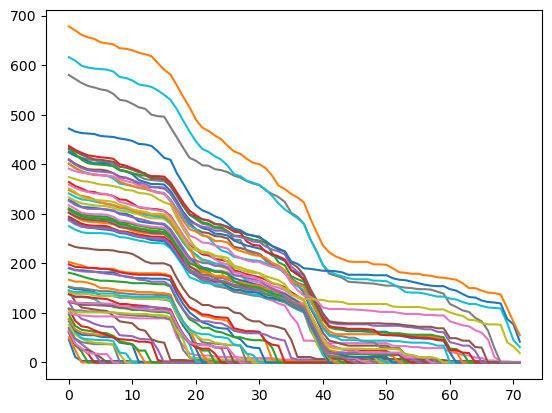

In [189]:
# plot demand change
import matplotlib as pyplot
demand_log = pd.DataFrame(demand_log)[done_groups]
fig, ax = plt.subplots()

x = np.arange(demand_log.shape[0])
for row in demand_log.to_numpy().T:
    ax.plot(x, row)

In [75]:
# alternative: place most required groups first
# iterate & sort students
sorted_students = pd.DataFrame(False, index = places_tab.index, columns = places_tab.columns)

places_tab2 = places_tab.copy()

done_groups = []

for group_idx in np.arange(places_tab2.shape[1]):
    demand = places_tab2.drop(columns=done_groups).sum(axis=0).sort_values(ascending=False)
    most_wanted = demand.index[0]
    
    group_candidates = places_tab2.loc[:, most_wanted]
    
    # get students to keep (certified students first)
    certified_candidates = certified.loc[group_candidates].values
    try:
        selected_candidates = select_students(group_candidates, np.full(certified_candidates.shape[0], False), certified_candidates, max_places.loc[most_wanted])
    except Exception as excp:
        print(f'Group {group_idx}: {excp}')
    places_tab2[most_wanted] = False
    places_tab2.loc[selected_candidates] = False
    sorted_students.loc[selected_candidates, most_wanted] = True
    done_groups.append(most_wanted)

#sorted_students = np.array(sorted_students)

# record students that were left without a group
#no_group_students = sorted_students.sum(axis=0) == 0

In [84]:
sorted_students.sum(axis=0).sort_values().value_counts()

35    28
0      9
3      5
4      4
1      4
2      3
8      3
11     3
5      2
19     2
10     1
6      1
15     1
20     1
24     1
26     1
30     1
32     1
12     1
Name: count, dtype: int64

In [80]:
places_tab2.shape

(1595, 72)

## Fase de acomodación
Es posible que al final de la fase de asignación queden algunos estudiantes sin grupo asignado. Antes de asignarlos a un grupo que no pidieron, podemos evaluar relocalizar alguno de los estudiantes ya asignados, en caso de haber seleccionado algún grupo que esté por debajo del limite.

En esta fase:
1) Construimos una matriz de transferencia de tamaño $n \times n$ en la que se indica cuantos estudiantes asignados a cada grupo pueden ser transferidos a algún otro grupo.
|||Grupos destino|||
|:-:|:-:|:-:|:-:|:-:|
|||$B$|$C$|
|**Grupos origen**|$A$|$T^A_B$|$T^A_C$|

Siendo $T^A_B$ y $T^A_C$ el numero de estudiantes asignados al grupo $A$ que podrían transferirse al grupo $B$ o al grupo $C$ respectivamente

2) ~Las columnas de los grupos destino que se encuentren saturados son eliminadas de la tabla, ya que no es posible transferir estudiantes a las mismas.~
2) ~Se seleccionan las filas de los grupos origen que fueron solicitados por los estudiantes sin grupo asignado~
3) ~Se calcula el maximo de estudiantes transferibles de para cada grupo requerido~
4) ~Iterativamente se transfieren estudiantes fuera de los grupos requeridos para colocar estudiantes que quedaron fuera~
    1) ~Los estudiantes sin grupo se ordenan en función del numero de opciones (ascendente)~
    2) ~Se selecciona entre sus opciones aquella con el mayor numero de transferencias posible~
    3) ~Se coloca al estudiante, desplazando a uno de los ya asignados a una de sus opciones alternativas (la menos saturada)~
___
2) Se ordenan los estudiantes excluidos en función del numero de alternativas presentadas (ascendente)
2) Para cada estudiante se busca recursivamente para cada una de sus opciones una cadena de transferencia que libere un lugar para colocarlo/a:
    1) Seleccionar los candidatos de transferencia de todas las opciones del estudiante, si alguno no está saturado, desplazar estudiantes a lo largo de la cadena de transferencias para generar un lugar para el estudiante
    2) Si todos los candidatos estan saturados, inspeccionar *sus* candidatos de transferencia
    3) Continuar recursivamente hasta encontrar una cadena de transferencias
    4) Para evitar recursión infinita, omitir candidatos ya visitados (es posible que no haya una cadena de transferencias posible)